In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\IMMACULATE.MUSYOKA\AppData\Roaming\Python\Python37\site-packages\setuptools\_importlib.py:23: UserWarning: `importlib-metadata` version is incompatible with `setuptools`.
This problem is likely to be solved by installing an updated version of `importlib-metadata`.
  warnings.warn(msg)  # Ensure a descriptive message is shown.


In [2]:
df=pd.read_csv("data.csv")
df.head()

,Date,Amount
0,2-Jan-20,0.002
1,3-Jan-20,0.003
2,4-Jan-20,35000.003
3,5-Jan-20,35000.004
4,6-Jan-20,35000.005


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
Date      139 non-null object
Amount    139 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.2+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].head()

0   2020-01-02
1   2020-01-03
2   2020-01-04
3   2020-01-05
4   2020-01-06
Name: Date, dtype: datetime64[ns]

(array([737425., 737446., 737456., 737477., 737485., 737506., 737516.,
        737537., 737546., 737567.]), <a list of 10 Text xticklabel objects>)

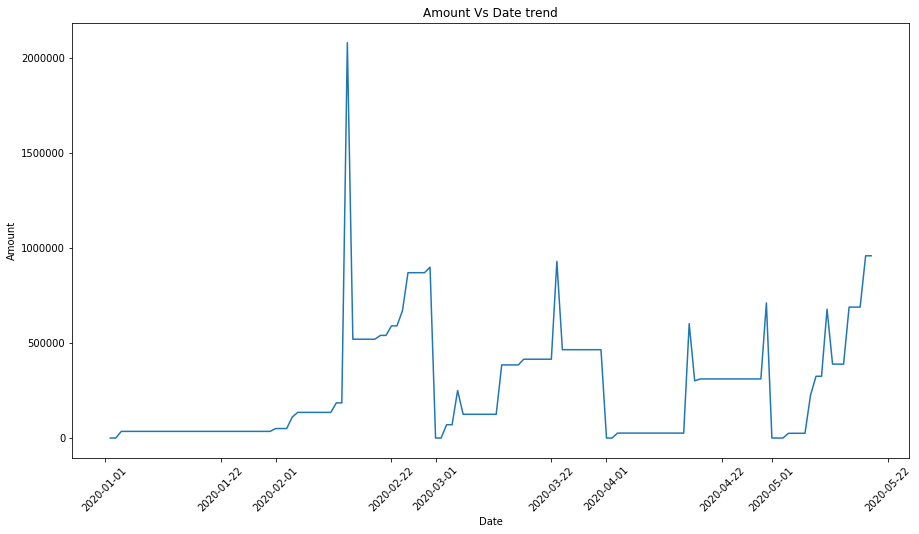

In [6]:
#plot the rlnship btw amount and date
plt.figure(figsize=(15,8))
sns.lineplot(x=df["Date"b],y=df["Amount"])
plt.title("Amount Vs Date trend")
plt.xticks(rotation=45)

In [7]:
df.set_index("Date",drop=True, inplace=True)

In [10]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

In [11]:
#split the data into training and testing
# freq is monthly in our data

training_data = ListDataset(
    [{"start": df.index[0], "target": df.Amount[:"2020-04-01T00:00:00.000000"], }],
    freq = "M"
)

In [14]:
df.tail()

,Amount
Date,
2020-05-15,689000.009
2020-05-16,689000.010
2020-05-17,689000.011
2020-05-18,959000.011
2020-05-19,959000.012


In [15]:
# Test data
test_data = ListDataset(
    [{"start": df.index[0], "target": df.Amount[:"2020-05-01T00:00:00.000000"]}],
    freq = "M"
)

## DeepAR model

In [17]:
from gluonts.mx import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

## Model Training

In [19]:
callbacks = [
    LearningRateReduction(objective="min",
                          patience=10,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]


estimator = DeepAREstimator(
    freq="M",
    prediction_length=24,
    context_length=36,
    num_layers = 2,
    num_cells = 40,
    distr_output=StudentTOutput(),
    dropout_rate=0.01,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=20,
                    callbacks=callbacks))

predictor = estimator.train(training_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:07<00:00,  2.56s/it, epoch=20/20, avg_epoch_loss=11.3]


## Evaluate

In [121]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [122]:
forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]


In [125]:
import pandas as pd
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
    

      
    

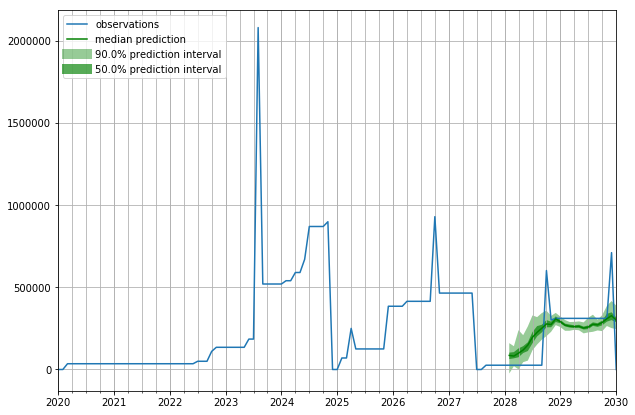

In [126]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [62]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

import json
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.96it/s]

{
    "MSE": 21561955669.333332,
    "abs_error": 2442800.0,
    "abs_target_sum": 5554000.0,
    "abs_target_mean": 231416.66666666666,
    "seasonal_error": 300862.35294117645,
    "MASE": 0.33830531583070367,
    "MAPE": 12410632.0,
    "sMAPE": 0.6517546971638998,
    "MSIS": 6.948893116388317,
    "QuantileLoss[0.1]": 1749089.933984375,
    "Coverage[0.1]": 0.2916666666666667,
    "QuantileLoss[0.2]": 2155661.621875,
    "Coverage[0.2]": 0.375,
    "QuantileLoss[0.3]": 2336909.67578125,
    "Coverage[0.3]": 0.375,
    "QuantileLoss[0.4]": 2420037.65,
    "Coverage[0.4]": 0.375,
    "QuantileLoss[0.5]": 2442799.9453125,
    "Coverage[0.5]": 0.375,
    "QuantileLoss[0.6]": 2422467.9250000003,
    "Coverage[0.6]": 0.4166666666666667,
    "QuantileLoss[0.7]": 2349184.2234375,
    "Coverage[0.7]": 0.4583333333333333,
    "QuantileLoss[0.8]": 2198738.69375,
    "Coverage[0.8]": 0.4583333333333333,
    "QuantileLoss[0.9]": 1916370.53125,
    "Coverage[0.9]": 0.5,
    "RMSE": 146839.89808